In [41]:
from utils import *
from fastai.vision import *
from fastai.widgets import *
import matplotlib as mpl
import seaborn as sns
# from fastai2.vision.widgets import *
# from fastai2.vision.all import *
# from fastai2.vision import *
# from fastai2.vision.utils import *
# from fastai2.imports import *
# from fastai2.data import *
# from fastai2.data.transforms import *
# from fastai2.data.block import *

In [56]:
# Set matplotlib default plot size: 
mpl.rcParams['figure.figsize'] = [10,5]
viz_dict = {
    'axes.titlesize':14,
    'axes.labelsize':12,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

# Squash Classifier

I love winter squash. I typically hate summer squash. This classifier will help me make sure that I never accidentally purchase a zucchini squash when what I really want is an acorn squash.

# Take-aways from this lesson:

1. Clean your data by hand if the ImageCleaner isn't providing good results. It's likely that the top losses do not contain a good picture of your noisy data. 

2. The Data Block API is important, but a shortcut method is used in this lesson that hides the important details. Those details are hightlighted in Lesson 3. 

In [43]:
path = Path('data/squash')

In [44]:
classes = ['butternut', 'pumpkin', 'acorn', 'zucchini', 'tromboncino', 'spaghetti', 'kabocha', 'patty', 'red kuri', 'sweet dumpling']

In [45]:
# create directories for training data
for type in classes:
    folder = type
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [46]:
# make sure all my directories are in place
path.ls()

[PosixPath('data/squash/red kuri.txt'),
 PosixPath('data/squash/pumpkin'),
 PosixPath('data/squash/pumpkin.txt'),
 PosixPath('data/squash/tromboncino.txt'),
 PosixPath('data/squash/acorn.txt'),
 PosixPath('data/squash/cleaned.csv'),
 PosixPath('data/squash/spaghetti.txt'),
 PosixPath('data/squash/spaghetti'),
 PosixPath('data/squash/tromboncino'),
 PosixPath('data/squash/.ipynb_checkpoints'),
 PosixPath('data/squash/acorn'),
 PosixPath('data/squash/red kuri'),
 PosixPath('data/squash/butternut.txt'),
 PosixPath('data/squash/kabocha'),
 PosixPath('data/squash/models'),
 PosixPath('data/squash/sweet dumpling'),
 PosixPath('data/squash/patty.txt'),
 PosixPath('data/squash/kabocha.txt'),
 PosixPath('data/squash/zucchini.txt'),
 PosixPath('data/squash/zucchini'),
 PosixPath('data/squash/butternut'),
 PosixPath('data/squash/patty'),
 PosixPath('data/squash/sweet dumpling.txt')]

In [5]:
for type in classes:
    download_images(path/f'{type}/', path/f'{type}.txt')    

In [47]:
file_names = get_image_files(path, recurse=True)
len(file_names)

1780

In [48]:
# verify all the URLs work and the images aren't broken:
for c in classes:
    print(c)
    verify_images(path/c, delete=False, max_size=500)
    

butternut


pumpkin


acorn


zucchini


tromboncino


spaghetti


kabocha


patty


red kuri


sweet dumpling


## Data Block API Summary:

The Data Block API is essentially a data-pipeline that runs from the data source (folders containing images, text, etc.) to a bundled data package that can be used by a model for learning purposes. That final package that a model can actually use is called a `DataBunch`.

The pipeline looks like this:

__data source $\rightarrow$ data split $\rightarrow$ data labeling $\rightarrow$ (Optional) create test set $\rightarrow$ data augmentation $\rightarrow$ wrap data in DataBunch object__

The code that would run our data through the above pipeline might look like this, in the case where images were stored in folders by label:

```
 data = (ImageList.from_folder(path)    #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

```

However, there is a shortcut method that we can use if our data is stored in the format where each type or class of item is stored in its own folder. For example, images of pumpkins go in a 'pumpkin' folder. 

In [49]:
# Create databunch
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

The above snippet of code is a shortcut for the specific instance when our data is stored according to class label. There are other methods, such as creating an `ImageDataBunch` from a .csv file containing the file locations and labels, or from a `Pandas.DataFrame`.

In our case, we are using "Imagenet-style" file structure, so the `ImageDataBunch.from_folder` method is perfect. 

However, we must take into account how training and validation data is split. This shortcut method allows for two options:

1. Store training and validation datasets in folders named 'train' and 'valid'. the `.from_folder` method will automatically detect this and split the data accordingly.

2. Use the optional argument `valid_pct` to randomly select a percentage of data you want to hold out as a validation test. Use this method if your data is not split into 'train' and 'valid' folders. 

In our specific case,  we used method 2, since we did not split our data into training and validation folders.

In [50]:
ImageDataBunch.from_folder?

In [51]:
#Show classifications:
data.classes

['acorn',
 'butternut',
 'kabocha',
 'patty',
 'pumpkin',
 'red kuri',
 'spaghetti',
 'sweet dumpling',
 'tromboncino',
 'zucchini']

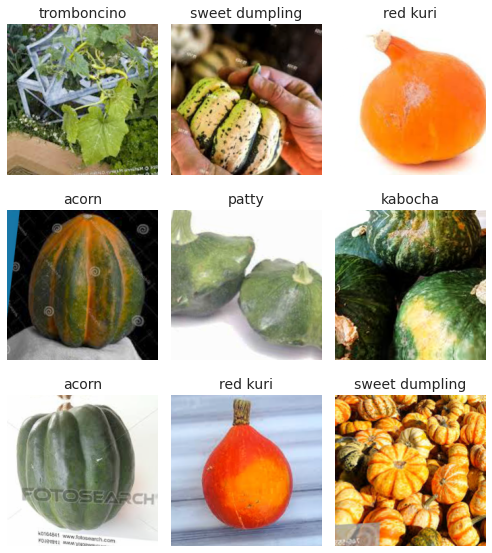

In [52]:
# peak at the data:
data.show_batch(rows=3, figsize=(7,8))

## Train a Model, Part 1: Learning Rate

Now that we have our data in a `DataBunch` wrapper that contains all of the information a model needs:

- labels
- train/validation split
- data augmentation (transformations)

We can feed our data bunch to a model so that it can begin to learn. We will start by finding an appropriate learning rate:

In [53]:
# create convolutional neural network:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [54]:
# Look for appropriate learning rate:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


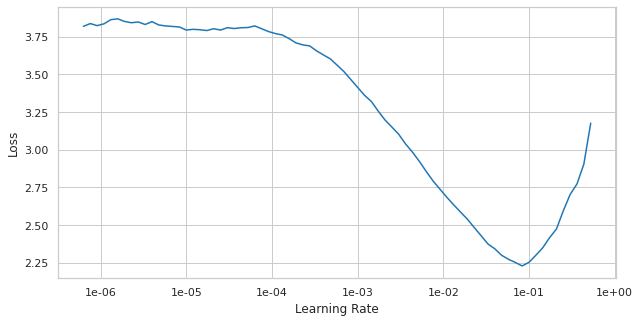

In [57]:
# We want to use the steepest slope for our learning rate:
learn.recorder.plot()

By my eyeballing, it looks like the steepest slope occurs before 1e-2. This is the max learning rate we will feed to our model for its first round of fitting:

In [58]:
learn.fit_one_cycle(4, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.657820,0.759912,0.199438,02:21
1,0.966975,0.620449,0.160112,02:20
2,0.669916,0.555952,0.157303,02:21
3,0.510513,0.518815,0.148876,02:21


Now that we have run our model for a few 'epochs' (one full cycle of all data being seen by the model), we see that our final error rate over 4 epochs is ~0.15. That means our model is approximately 85 percent accurate. Let's save this progress so that it is not lost during future experimentation:

In [60]:
learn.save('stage-1-resnet34')

Then, we can fine-tune our model. We will "unfreeze" the model, which means that every layer of the neural net will be able to continue learning, rather than just the final layer:

In [61]:
learn.unfreeze()

And again look at our learning rate:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


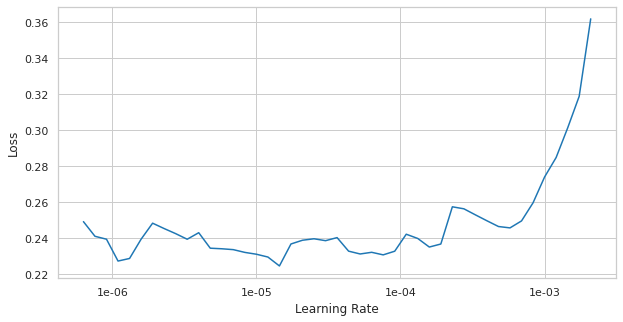

In [62]:
learn.lr_find()
learn.recorder.plot()

This time, our learning rate plot looks a little bumpier, but we still see that there is a distinct overall downward trend up to about 5e-4. Let's train our model some more with that in mind:

In [63]:
learn.fit_one_cycle(4, max_lr=slice(5e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.267119,0.517475,0.143258,03:16
1,0.245064,0.523004,0.151685,03:16
2,0.259216,0.516467,0.148876,03:17
3,0.247843,0.515243,0.151685,03:16


In [64]:
learn.save('stage-2-rnet34')

## Interpretation
With tuning and training for a few more epochs, we see that our error rate has droped by a percent or two, so we are making good progress. Now, let's take a look at what our model is getting right and wrong, and see if we can't garner some information that will help make our model even better:

In [ ]:
learn.load('stage-2-rnet34')

In [66]:
interp = ClassificationInterpretation.from_learner(learn)

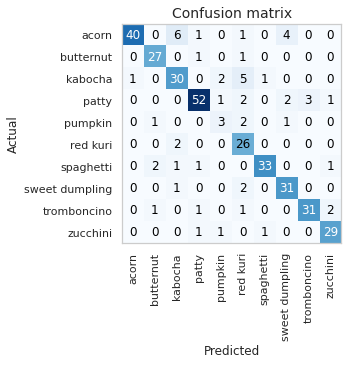

In [67]:
interp.plot_confusion_matrix()

Overall, it looks like our model does pretty well, with some understandable exceptions. There seems to be a lot of confusion between pumpkins and kabocha squash, kabocha and acorn, as well as red kuri and kabocha. I think if you Google these types of squash, you too might have a hard time distinguishing them. 

One thing to note, is that there are very few great pictures of pumpkins out there. It was an interesting discovery for me, and I hypothesize that finding more good, clear pictures of pumpkins would help improve our model. 

## Loss

Loss is a term that describes how wrong our model was in its predictions. It is essentially a penalty for our model being "wrong". For example, if the neural net predicted that a certain image had 99% probability of being a pumpkin, but that image was actually of a zucchini, then loss would be very high. However, if it predicted that image was of a pumpkin with only 55% probability, but the image was actually a zucchini, then loss would be lower.  

Let's take a look at those images with the greatest loss:

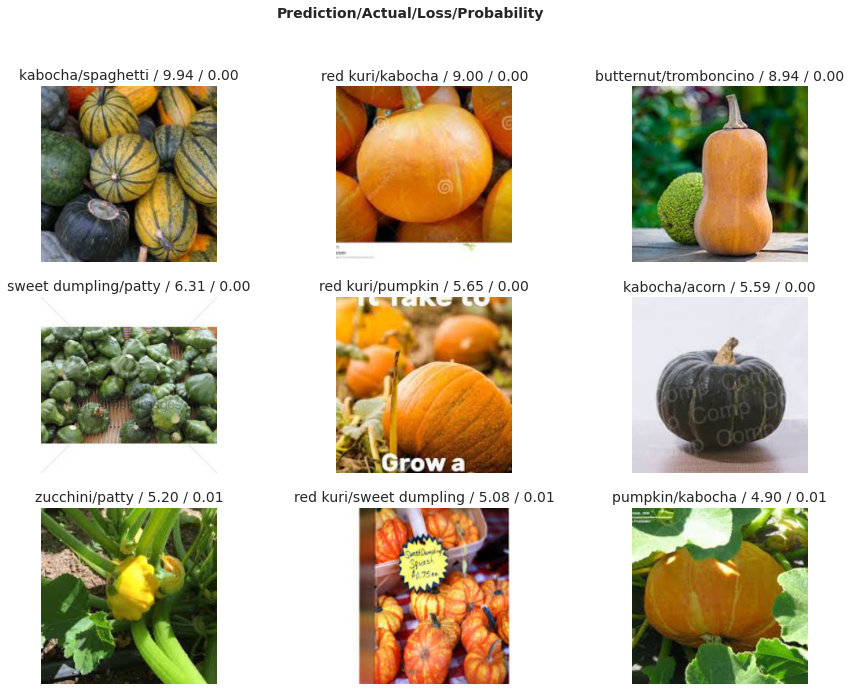

In [68]:
interp.plot_top_losses(9, figsize=(15,11))

The first image was predicted to be butternut, which it clearly is. However, it looks like the label was wrong! In other instances, we see confusion between Kabocha Pumpkins and Red Kuri squash, which all share very similar features. I'd probably be quite confused myself! 

## Cleaning Up

As mentioned above, some of our losses come from mislabeled images, or images that aren't of sqush at all. We can improve our model's performance by fixing labels and deleting bad data. We will do this with an `ImageCleaner` object. 

In order to clean up all of our data, we will need a `DataBunch` that is not split into train and validate. 

In [69]:
db = (ImageList.from_folder(path)
      .split_none()
      .label_from_folder()
      .transform(get_transforms(), size=224)
      .databunch()
     )

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [ ]:
learn_cln.load('stage-2-rnet34')

In [73]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [74]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

The changes we make with the `ImageCleaner` do not take affect directly on disk. Rather, the changes are stored in the form of a csv file from which we create a new `DataBunch` object.

In [75]:
cleaned_data = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv', valid_pct=0.2, 
                                       ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [76]:
cln_learner = cnn_learner(cleaned_data, models.resnet34, metrics=error_rate)

In [ ]:
cln_learner.load('stage-2-rnet34')

In [78]:
cln_learner.unfreeze()

In [79]:
cln_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


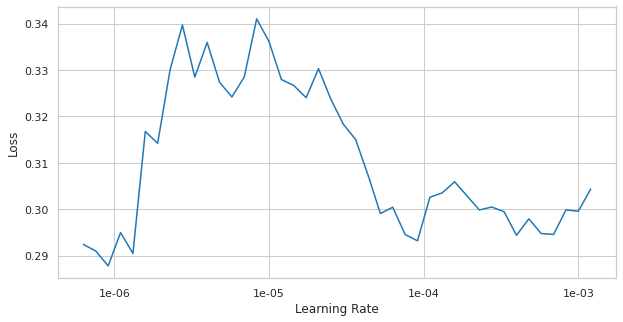

In [80]:
cln_learner.recorder.plot()

In [84]:
cln_learner.fit_one_cycle(5, max_lr=slice(6e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.306452,0.213359,0.059659,03:16
1,0.256181,0.230863,0.065341,03:16
2,0.223952,0.176426,0.059659,03:16
3,0.174349,0.178825,0.048295,03:16
4,0.142138,0.183642,0.053977,03:16


In [85]:
# export the model parameters:
cln_learner.save('stage-3-rnet34')
cln_learner.export()

In [86]:
# Check to see if the model was exported:


TypeError: <lambda>() got an unexpected keyword argument 'file_exts'

In [ ]:
learn = cnn_learner()